c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa


Training on snapshot 1/10: file_data_12_27_40.csv
Non-zero sat→cell visibility entries: 127531
Sample Satellite: {'sat_id': 1270, 'latitude': 32.43304213176279, 'longitude': -98.14916954687342, 'altitude': 544.9384167459549, 'visible_gateways': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0], 'memory': [], 'timestamp': None}
[Epoch 001] Loss: 58.1932 | GW-Coverage: 90.74% | Cell-Coverage: 99.52%
[Epoch 002] Loss: 57.5888 | GW-Coverage: 88.89% | Cell-Coverage: 99.52%
[Epoch 003] Loss: 57.0114 | GW-Coverage: 90.74% | Cell-Coverage: 99.52%
[Epoch 004] Loss: 56.4272 | GW-Coverage: 92.59% | Cell-Coverage: 99.52%
[Epoch 005] Loss: 55.7516 | GW-Coverage: 96.30% | Cell-Coverage: 99.52%
[Epoch 006] Loss: 55.0348 | GW-Coverage: 96.30% | Cell-Coverage: 99.52%
[Epoch 007] Loss: 54.1617 | GW-Coverage: 98.15% | Cell-Coverage: 99.52%
[Epoch 008] Loss: 53.2768 | GW-Coverage: 98.15% | Cel

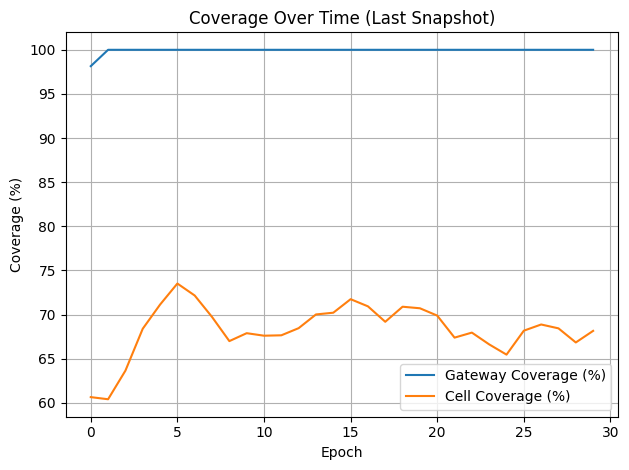

In [1]:
# === Imports ===
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import random

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN
from src.train import train_until_converged

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Helper: Binning satellites ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Snapshot files ===
#snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])[:5]
all_snapshot_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
snapshot_files = random.sample(all_snapshot_files, min(10, len(all_snapshot_files)))
# === Model State ===
hidden_dim = 64
model = None
optimizer = None
memory_dict = {}
bin_size = 1.0

# === Training across snapshots ===
for idx, file in enumerate(snapshot_files):
    print(f"\nTraining on snapshot {idx+1}/{len(snapshot_files)}: {file}")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells, timestep=idx)

    # Normalize features
    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)

    # Build visibility matrices
    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    cell_sat = torch.zeros((num_cells, num_sats))
    for sat, cell in data['sat', 'covers', 'cell'].edge_index.t():
        cell_sat[cell, sat] = 1

    print(f"Non-zero sat→cell visibility entries: {int(sat_cell.sum().item())}")
    print("Sample Satellite:", satellites[0])

    # Extract satellite positions
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_positions = list(zip(sat_lat, sat_lon))

    # Demand vector
    cell_demands = data['cell'].x[:, -2].unsqueeze(1)  # assuming demand is second last

    # Auxiliary inputs
    aux_inputs = {
        'sat_gateway': sat_gateway,
        'sat_cell': sat_cell,
        'cell_sat': cell_sat,
        'cell_demands': cell_demands
    }



    # Loss weights
    loss_weights = {
        'alpha': 10.0,   # gateway coverage
        'beta': 2.0,     # satellite to gateway assignment regularization
        'delta': 10.0,   # cell coverage
        'zeta': 0.1,     # satellite capacity
        'eta': 0.0,      # optional satellite-to-cell exclusivity
        'gamma': 5.0     # 🚀 Add this to properly weigh the new gateway exclusivity loss
    }


    # Initialize model first time
    if model is None:
        input_dims = {
            'sat': data['sat'].x.shape[1],
            'gateway': data['gateway'].x.shape[1],
            'cell': data['cell'].x.shape[1]
        }
        model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    model, history, final_outputs = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=30,
        patience=5,
        verbose=True,
        return_probs=True,
        memory_dict=memory_dict,
        sat_positions=sat_positions,
        bin_size=bin_size
    )

# Save final model
torch.save(model.state_dict(), "trained_sat_gateway_model_multi.pt")
print("\nModel saved as 'trained_sat_gateway_model_multi.pt'")

# Plot coverage
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import os
import torch
import pandas as pd
import torch.nn.functional as F
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN  # GNN model

# === Settings ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
hidden_dim = 64
cell_threshold = 0.02  # Threshold for deciding "covered" cells

# === List files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:5]  # Assume testing on first 5 time steps

# === Model Setup ===
# Dummy input to set up dimensions
dummy_satellites, dummy_gateways, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data = build_hetero_graph(dummy_satellites, dummy_gateways, dummy_cells, timestep=0)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Memory Setup ===
sat_memory_dict = {}  # {sat_id: memory vector}

# === Testing loop ===
for timestep, file in enumerate(files_to_test):
    print(f"\n=== Evaluating timestep {timestep} | file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells, timestep=timestep)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    visibility_matrices = {
        'sat_gateway': sat_gateway,
        'sat_cell': sat_cell,
        'cell_sat': torch.zeros((num_cells, num_sats))  # dummy for now
    }

    # Extract current real satellite IDs
    current_sat_ids = [sat['sat_id'] for sat in satellites]

    # Build memory input batch
    memory_list = []
    for sat_id in current_sat_ids:
        if sat_id in sat_memory_dict:
            memory_list.append(sat_memory_dict[sat_id])
        else:
            memory_list.append(torch.zeros(hidden_dim))  # Fresh memory
    sat_memory_batch = torch.stack(memory_list)

    # === Run inference ===
    with torch.no_grad():
        outputs = model(data, visibility_matrices=visibility_matrices, sat_memory=sat_memory_batch)

    sat_memory_out = outputs['sat_memory_out']
    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # === Update sat memory ===
    for sat_id, new_mem in zip(current_sat_ids, sat_memory_out):
        sat_memory_dict[sat_id] = new_mem.detach()

    # === Process Outputs ===
    results = []
    for idx, sat_id in enumerate(current_sat_ids):
        predicted_gw = torch.argmax(gateway_probs[idx]).item()

        visible_mask = sat_cell[idx] > 0
        assigned_mask = cell_probs[idx] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        results.append({
            "satellite_id": sat_id,
            "predicted_gateway": predicted_gw,
            "covered_cells": covered_cells
        })

    df = pd.DataFrame(results)
    print(df)

    # === Coverage Evaluation ===
    covered_cells_all = set()
    for r in results:
        covered_cells_all.update(r['covered_cells'])

    cell_coverage_percentage = (len(covered_cells_all) / num_cells) * 100
    print(f"\n Cell coverage: {len(covered_cells_all)} / {num_cells} = {cell_coverage_percentage:.2f}%")

    predicted_gateways = set(df['predicted_gateway'])
    gateway_coverage_percentage = (len(predicted_gateways) / num_gws) * 100
    print(f" Gateway coverage: {len(predicted_gateways)} / {num_gws} = {gateway_coverage_percentage:.2f}%")



=== Evaluating timestep 0 | file: file_data_00_00_00.csv ===
     satellite_id  predicted_gateway  \
0            1479                 45   
1              30                 50   
2             188                 12   
3             189                 19   
4            1434                 36   
..            ...                ...   
107           325                 25   
108          1455                 12   
109           257                 31   
110          1569                 12   
111            51                 40   

                                         covered_cells  
0    [0, 1, 4, 5, 7, 12, 13, 18, 19, 21, 25, 26, 27...  
1    [1, 3, 7, 9, 10, 13, 17, 20, 21, 24, 27, 28, 2...  
2    [2, 9, 11, 14, 15, 16, 22, 23, 31, 32, 34, 35,...  
3    [3, 9, 10, 14, 15, 17, 28, 30, 31, 38, 43, 45,...  
4    [0, 4, 5, 12, 18, 21, 25, 27, 44, 46, 50, 51, ...  
..                                                 ...  
107  [2, 3, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19, 23...  
1

In [ ]:
import os
import torch
import pandas as pd
import torch.nn.functional as F
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN

# === Settings ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
hidden_dim = 64
cell_threshold = 0.1  # Threshold to decide "coverage" from sigmoid output

# === List files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:2] + snapshot_files[-2:]  # First 2 + Last 2

# === Model Setup ===
dummy_satellites, dummy_gateways, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data = build_hetero_graph(dummy_satellites, dummy_gateways, dummy_cells, timestep=0)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Testing Loop ===
for file in files_to_test:
    print(f"\n=== Evaluating on file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells, timestep=0)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Mapping: internal sat index → real feed_satellite_id
    id_mapping = {idx: sat['sat_id'] for idx, sat in enumerate(satellites)}

    # Run inference
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))  # dummy
        })

    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # Generate Output
    results = []
    for sat_internal_id in range(num_sats):
        real_sat_id = id_mapping[sat_internal_id]

        predicted_gw = torch.argmax(gateway_probs[sat_internal_id]).item()

        visible_mask = sat_cell[sat_internal_id] > 0
        assigned_mask = cell_probs[sat_internal_id] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        results.append({
            "real_satellite_id": real_sat_id,
            "predicted_gateway": predicted_gw,
            "covered_cells": covered_cells
        })

    df = pd.DataFrame(results)
    print(df)

    # === Coverage Evaluation ===
    covered_cells_all = set()
    for r in results:
        covered_cells_all.update(r['covered_cells'])

    cell_coverage_percentage = (len(covered_cells_all) / num_cells) * 100
    print(f"\n Cell coverage: {len(covered_cells_all)} / {num_cells} = {cell_coverage_percentage:.2f}%")

    predicted_gateways = set(df['predicted_gateway'])
    gateway_coverage_percentage = (len(predicted_gateways) / num_gws) * 100
    print(f" Gateway coverage: {len(predicted_gateways)} / {num_gws} = {gateway_coverage_percentage:.2f}%")


In [2]:
import os
import random
import torch
from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === Paths ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
hidden_dim = 64

# === Random test snapshots ===
all_files = sorted(os.listdir(folder_path))
test_files = random.sample(all_files, 5)

# === Load model once ===
first_file = test_files[0]
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=first_file)
data = build_hetero_graph(satellites, gateways, cells, timestep=0)

input_dims = {
    'sat': data['sat'].x.shape[1],
    'gateway': data['gateway'].x.shape[1],
    'cell': data['cell'].x.shape[1],
}
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Run predictions and summarize ===
for idx, file in enumerate(test_files):
    print(f"\n>>> Testing snapshot {idx+1}: {file}")
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells, timestep=idx)

    with torch.no_grad():
        gw_logits, cell_logits, _ = model(data)

    print("  → Satellites:", data['sat'].num_nodes)
    print("  → Gateways  :", data['gateway'].num_nodes)
    print("  → Cells     :", data['cell'].num_nodes)
    print("  → GW logits shape:", gw_logits.shape)
    print("  → Cell logits shape:", cell_logits.shape)



>>> Testing snapshot 1: file_data_09_14_00.csv
  → Satellites: 111
  → Gateways  : 54
  → Cells     : 4569
  → GW logits shape: torch.Size([111, 54])
  → Cell logits shape: torch.Size([111, 4569])

>>> Testing snapshot 2: file_data_00_49_20.csv
  → Satellites: 108
  → Gateways  : 54
  → Cells     : 4569
  → GW logits shape: torch.Size([108, 54])
  → Cell logits shape: torch.Size([108, 4569])

>>> Testing snapshot 3: file_data_06_18_00.csv
  → Satellites: 106
  → Gateways  : 54
  → Cells     : 4569
  → GW logits shape: torch.Size([106, 54])
  → Cell logits shape: torch.Size([106, 4569])

>>> Testing snapshot 4: file_data_09_12_20.csv
  → Satellites: 112
  → Gateways  : 54
  → Cells     : 4569
  → GW logits shape: torch.Size([112, 54])
  → Cell logits shape: torch.Size([112, 4569])

>>> Testing snapshot 5: file_data_04_45_20.csv
  → Satellites: 104
  → Gateways  : 54
  → Cells     : 4569
  → GW logits shape: torch.Size([104, 54])
  → Cell logits shape: torch.Size([104, 4569])


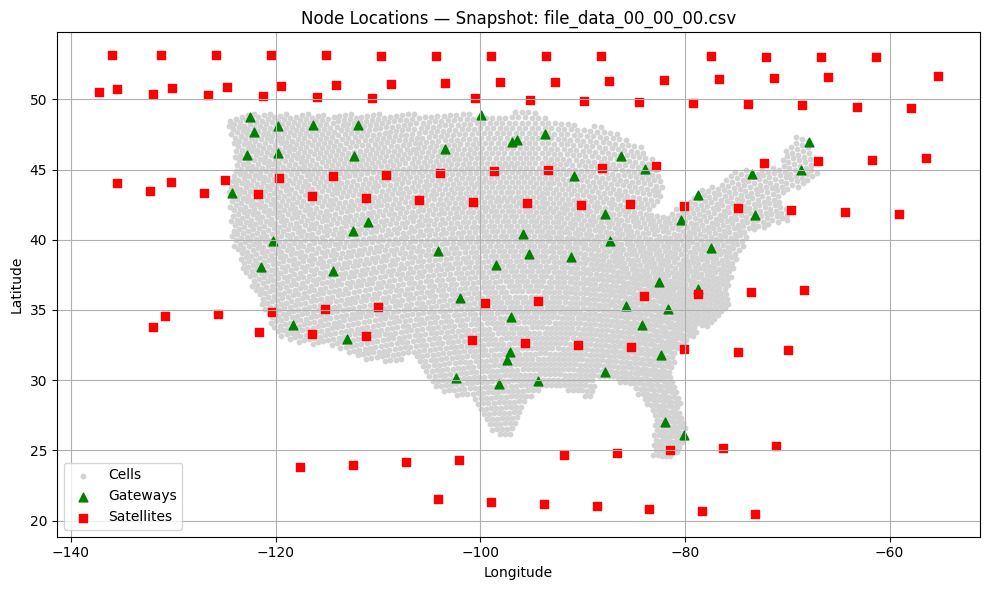

In [4]:
import os
import torch
import matplotlib.pyplot as plt
from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph

# === File Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
snapshot_file = "file_data_00_00_00.csv"  # Pick a file you want to visualize

# === Load snapshot ===
sats, gws, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=snapshot_file)
data = build_hetero_graph(sats, gws, cells, timestep=0)

# === Extract lat/lon ===
sat_pos = data['sat'].x[:, :2].detach().cpu().numpy()      # assume [lat, lon] is in first 2 features
gw_pos = data['gateway'].x[:, :2].detach().cpu().numpy()
cell_pos = data['cell'].x[:, :2].detach().cpu().numpy()

# === Plot ===
plt.figure(figsize=(10, 6))
plt.scatter(cell_pos[:, 1], cell_pos[:, 0], s=10, c='lightgray', label='Cells', marker='o')    # lon, lat
plt.scatter(gw_pos[:, 1], gw_pos[:, 0], s=40, c='green', label='Gateways', marker='^')
plt.scatter(sat_pos[:, 1], sat_pos[:, 0], s=40, c='red', label='Satellites', marker='s')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Node Locations — Snapshot: {snapshot_file}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
